# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [ ]:
pd.read_excel('data/')

In [4]:
c14_patient_data = pd.read_excel('data/C14data_liver_samples.xlsx')[['sort', 'Code', 'DOB', 'DOA', u'Δ 14C']]
c14_patient_data.columns = ['type', 'pub_id', 'Dbirth', 'Dcoll', 'd14C']
c14_patient_data['mass'] = 1.0
c14_patient_data['d14C'] /= 1000.0

In [5]:
exp_data = c14_patient_data.query('type == "hepatocyte"')
exp_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


# SSE & log-likelihood

In [6]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [7]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [8]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [9]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1(Dbirth, Dcoll, lam, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [10]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(10.0))],
                  args = (I1, exp_data),
                  Ns = 50,
                  full_output = True,
                  finish=None)

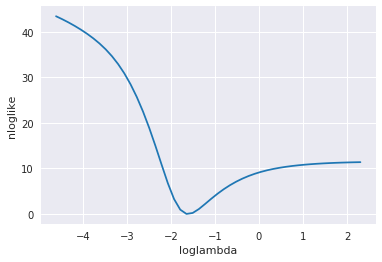

In [11]:
plt.plot(res[-2], res[-1]-res[1])

plt.xlabel('loglambda')
plt.ylabel('nloglike')

plt.show()

In [138]:
res_I1 = sp.optimize.minimize(fun=Nloglike, 
                     x0=[-1.0],
                     args = (I1, exp_data),
                     method="Nelder-Mead"
                    )

## Result

In [152]:
print('lamda', sp.exp(res_I1.x[0]))

print('sigma', Sigma(res_I1.x, I1, exp_data))

results.loc['I1', 'loglike'] = -res_I1.fun
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.20016890376789742
sigma 0.0168039257035579


,loglike,k,n,cAIC
I1,50.676880,2.0,19.0,-96.603760
I1T_step,51.456647,4.0,19.0,-92.056151
I1T_transient,52.932734,5.0,19.0,-91.250084


# I1T_step

In [17]:
I1T = c14_models.I1T

In [65]:
@np.vectorize
def I1T_step(Dbirth, Dcoll, loglam1, loglam2, t_step):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_step(t, lam1, lam2, t_step):
        return np.where(t < Dbirth + t_step, lam1, lam2)
    
    return I1T(Dbirth, Dcoll, lam_step, t_eval=np.linspace(Dbirth, Dcoll), lam_arg=(lam1, lam2, t_step))[1][-1]

In [61]:
I1T_step(1930, 2000, np.log(0.2), np.log(1.0), 80)

0.13208643302623235

## Fit

In [146]:
res_I1T_step = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2, -1, 30.0],
                           args = (I1T_step, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [150]:
print('lamda1', np.exp(res_I1T_step.x[0]))
print('lamda2', np.exp(res_I1T_step.x[1]))
print('t_step', res_I1T_step.x[2])

print('sigma', Sigma(res_I1T_step.x, I1T_step, exp_data))

results.loc['I1T_step', 'loglike'] = -res_I1T_step.fun
results.loc['I1T_step', 'k'] = 4
results.loc['I1T_step', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda1 0.43697366334158866
lamda2 0.18553058004573975
t_step 25.42082984784726
sigma 0.016128246335357293


,loglike,k,n,cAIC
I1,50.676880,2.0,19.0,-96.603760
I1T_step,51.456647,4.0,19.0,-92.056151
I1T_transient,52.932734,5.0,19.0,-91.250084


# I1T_transient

In [120]:
@np.vectorize
def I1T_transient(Dbirth, Dcoll, loglam1, loglam2, t_on, t_off):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_transient(t, lam1, lam2, t_on, t_off):
        return np.where(np.logical_or(t < Dbirth + t_on,
                                      t > Dbirth + t_on + t_off),
                        lam1, 
                        lam2)
    
    return I1T(Dbirth, Dcoll, lam_transient, 
               t_eval=np.linspace(Dbirth, Dcoll), 
               lam_arg=(lam1, lam2, t_on, t_off)
              )[1][-1]

## Fit

In [153]:
res_I1T_transient = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2.0, -3.0, 60.0, 70],
                           args = (I1T_transient, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [154]:
print('lamda1', np.exp(res_I1T_transient.x[0]))
print('lamda2', np.exp(res_I1T_transient.x[1]))
print('t_on', res_I1T_transient.x[2])
print('t_off', res_I1T_transient.x[3])

sig = Sigma(res_I1T_transient.x, I1T_transient, exp_data)
print('sigma', sig)

results.loc['I1T_transient', 'loglike'] = -res_I1T_transient.fun
results.loc['I1T_transient', 'k'] = 5
results.loc['I1T_transient', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda1 0.24563784150294754
lamda2 0.1256472160730866
t_on 59.808712314529714
t_off 77.9869853147656
sigma 0.014922697289172658


,loglike,k,n,cAIC
I1,50.676880,2.0,19.0,-96.603760
I1T_step,51.456647,4.0,19.0,-92.056151
I1T_transient,52.932734,5.0,19.0,-91.250084


# Plot I1, I1T

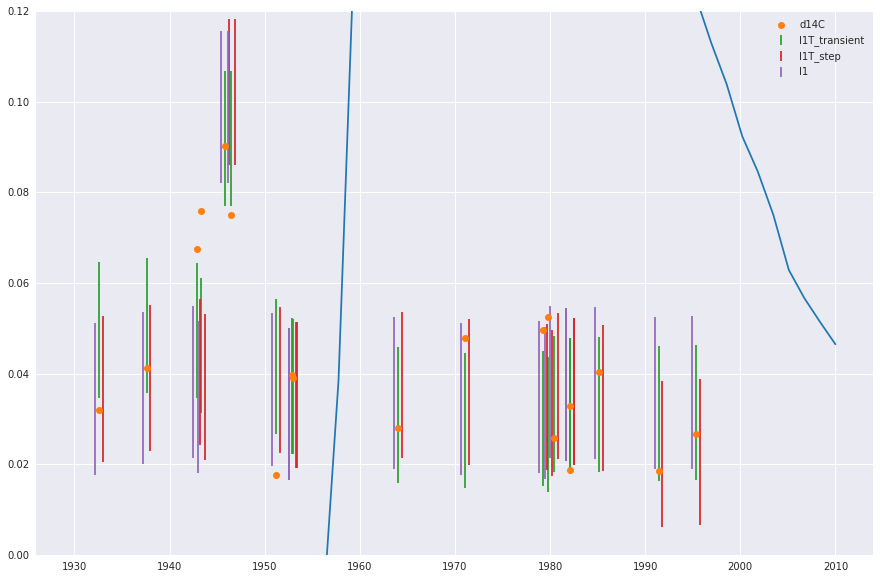

In [159]:
fig, ax = plt.subplots(figsize=(15, 10))
tt = np.linspace(1930, 2010)
ax.plot(tt, np.vectorize(c14_models.C_atm)(tt))
ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 'o')
ax.errorbar(exp_data['Dbirth'], 
            I1T_transient(exp_data['Dbirth'].values,
                          exp_data['Dcoll'].values,
                          *res_I1T_transient.x
                         ),
           Sigma(res_I1T_transient.x, I1T_transient, exp_data),
           ls='None',
           label = 'I1T_transient')

ax.errorbar(exp_data['Dbirth']+0.4, 
            I1T_step(exp_data['Dbirth'].values,
                          exp_data['Dcoll'].values,
                          *res_I1T_step.x
                         ),
           Sigma(res_I1T_step.x, I1T_step, exp_data),
           ls='None',
           label = 'I1T_step')

ax.errorbar(exp_data['Dbirth']-0.4, 
            I1(exp_data['Dbirth'].values,
               exp_data['Dcoll'].values,
               *res_I1.x
               ),
           Sigma(res_I1.x, I1, exp_data),
           ls='None',
           label = 'I1')

ax.set_ylim((0, 0.12))
ax.legend()
plt.show()

# IK

In [63]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [64]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-1.5, 1), (0.2, 0.95)],
                  args = (IK, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

TypeError: IK() missing 1 required positional argument: 'f'

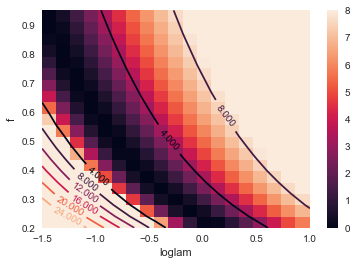

In [15]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [16]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IK, exp_data)
print('sigma', sig)

results.loc['IK', 'loglike'] = -res[1]
results.loc['IK', 'k'] = 3
results.loc['IK', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.560488043569
f 0.357894736842
sigma 0.0168040391187


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504


# IL

In [17]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [18]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.15789474  0.47421053]
-50.7317642285


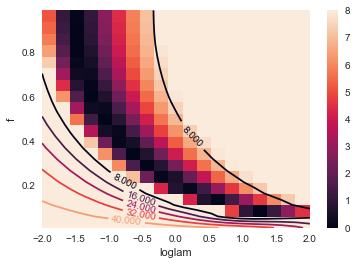

In [19]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [20]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IL, exp_data)
print('sigma', sig)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.314146846984
f 0.474210526316
sigma 0.0167554552472


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528


# I2

In [21]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [22]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3, 0.5), (0.85, 1)],
                  args = (I2, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-1.52631579  0.99210526]
-50.5808207182


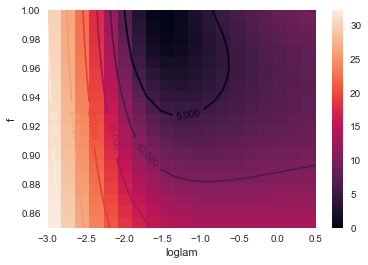

In [23]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [24]:
lam = sp.exp(res[0][0])
print('lamda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, exp_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lamda 0.217334901671
f 0.992105263158
sigma 0.0168890973567


,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528
I2,50.580821,3.0,19.0,-93.561641


# Scenario IX2p

In [25]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [26]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

[-2.8390644  -0.48425668  0.22222222]
-51.5940985725


## Result

In [27]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 4
results.loc['IX2p', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IK,50.676752,3.0,19.0,-93.753504
IL,50.731764,3.0,19.0,-93.863528
I2,50.580821,3.0,19.0,-93.561641
IX2p,51.594099,4.0,19.0,-92.331054


# Results

In [28]:
results.sort_values('cAIC')

,loglike,k,n,cAIC
I1,50.641325,2.0,19.0,-96.532650
IL,50.731764,3.0,19.0,-93.863528
IK,50.676752,3.0,19.0,-93.753504
I2,50.580821,3.0,19.0,-93.561641
IX2p,51.594099,4.0,19.0,-92.331054
